In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, Subset, DataLoader
from collections import Counter

from tqdm import tqdm


In [2]:
seed = 265
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
dtype = torch.float64
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)
validation_ratio = 0.2

In [3]:
data_cifar10 = datasets.CIFAR10(
            '../data/',             
            download=True,
            train=True
)

Files already downloaded and verified


In [4]:
#The cifar train dataset
data_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/
    Split: Train

In [5]:
#The distribution of the train dataset
np.unique(data_cifar10.targets, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [6]:
data_cifar10[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [7]:
data_cifar10.data[0].shape

(32, 32, 3)

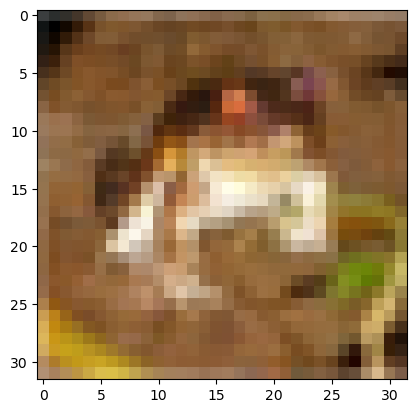

In [8]:
plt.imshow(data_cifar10[0][0])

In [9]:
data_cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The first datapoint is a PIL image with size 32x32 and target 6. It should resemble a frog. Borrowing code from the examples to showcase what all the targets looks like.

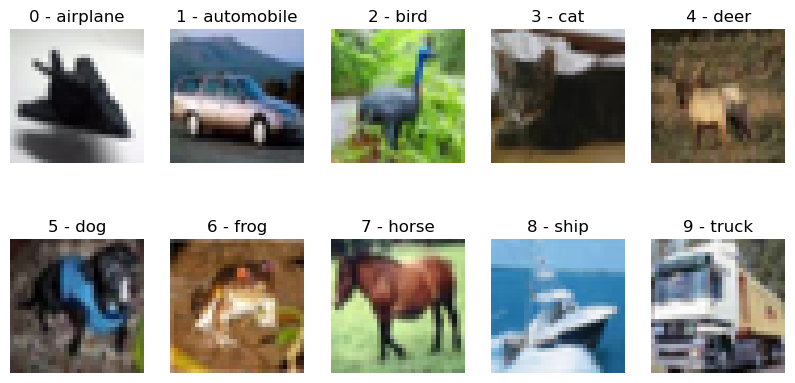

In [10]:
#From tutorial 1
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i, ax in enumerate(axes.flat):
    img = next(img for img, label in data_cifar10 if label == i)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{i} - {data_cifar10.classes[i]}')
    ax.axis('off')
    
plt.show()

In [11]:
print('Should we normalize?\n')

train_indices = [i for i, datapoint in enumerate(data_cifar10) if datapoint[1] in [0,2]]

data = data_cifar10.data[train_indices] /255
data_mean = data.mean(axis=(0,1,2))
data_std = data.std(axis=(0,1,2))
data_var = data.var(axis=(0,1,2))

print('mean: ' , data_mean)
print('std' , data_std)
print('variance' , data_var)


print('\nYes')

Should we normalize?

mean:  [0.50745266 0.5259032  0.5064758 ]
std [0.23961083 0.23365386 0.26792265]
variance [0.05741335 0.05459412 0.07178255]

Yes


This is like shown in the 1st tutorial. But it is generally recomended to normalize after splitting into different datasets.
Therefore I will compute mean and std again, but only on the training set, so there is no data leakage into the validation set. The test set is excluded from the data_cifar10 either way.  

In [12]:
#Importing cifar10 training set again transformed to tensors.
tensor_cifar10_train_val = datasets.CIFAR10('../data/', train=True, download=False,
                                        transform=ToTensor())

#Deciding the split
n_train = int(len(tensor_cifar10_train_val)*(1-validation_ratio))
n_val =  len(tensor_cifar10_train_val) - n_train

#Splitting to training and validation
data_train, data_val = random_split(
    tensor_cifar10_train_val, 
    [n_train, n_val],
    generator=torch.Generator().manual_seed(seed))

#Map the old targets to the new targets
targets_map = {0:0, 2:1}

#Getting the indices for target 0 and 2
cifar2_train = [(img, targets_map[label]) for img, label in data_train if label in [0, 2]]

#Get the images alone in a stack. And find the mean and std
imgs = torch.stack([img for img, _ in cifar2_train])
mean = imgs.mean(dim=(0, 2, 3))
std = imgs.std(dim=(0, 2, 3))

In [13]:
data_train

Normalization is generally a good idea. It can improve performance. Therefore we should now transform the data with normalization and make it usable for pytorch by turning them to tensors.

In [16]:
preprocessor = Compose([ 
    ToTensor(),
    Normalize(mean=mean, std = std)
])

In [17]:
def load_cifar10(datapath='../data/'):

    
    data_train_val = datasets.CIFAR10(
            datapath,       
            train=True,      
            download=True,
            transform = preprocessor)

    
    data_test = datasets.CIFAR10(
        datapath, 
        train=False,
        download=True,
        transform = preprocessor
    )


    n_train = int(len(data_train_val)*(1-validation_ratio))
    n_val =  len(data_train_val) - n_train
    
    data_train, data_val = random_split(
        data_train_val, 
        [n_train, n_val],
        generator=torch.Generator().manual_seed(seed)
    )
    
    return data_train, data_val, data_test

In [18]:
cifar2_train, cifar2_val, cifar2_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [19]:
len(cifar2_train)

40000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


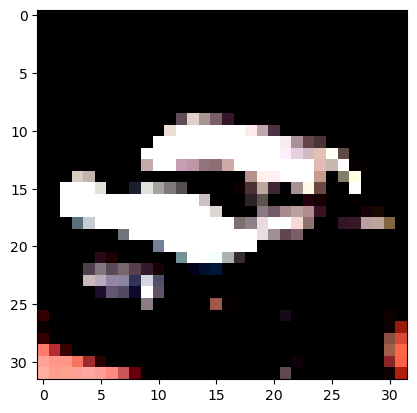

In [20]:
#How the image looks after normalization
plt.imshow(cifar2_train[0][0].permute(1,2,0))

In [21]:
#Making a dictionary with the keys of the original targets, and value of the new targets.
label_map = {0:0, 2:1}
#Getting the class names from dataset classes
class_names = [data_cifar10.classes[i] for i in [0,2]]

#Creating a new subset based on indices where the target is 0 or 2

cifar2_train = [(img, targets_map[label]) for img, label in cifar2_train if label in [0, 2]]

cifar2_val = [(img, targets_map[label]) for img, label in cifar2_val if label in [0, 2]]

cifar2_test = [(img, targets_map[label]) for img, label in cifar2_test if label in [0, 2]]

Now we also only want to train with class 0 and 2. Whe should then make a subset where 0 and 2 becomes 0 and 1.

Counter({1: 3992, 0: 3971})

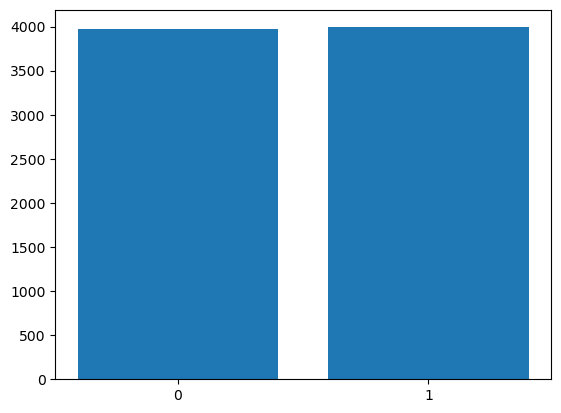

In [22]:
#The distribution of the training subset
train_distribution = Counter([label for _, label in cifar2_train])
plt.bar([str(x) for x in train_distribution.keys()], train_distribution.values())
train_distribution

In [23]:
train_targets_distribution = np.array(list(train_distribution.values()))
train_targets_distribution.mean(), train_targets_distribution.std()

(3981.5, 10.5)

The random split between train and validation kept the subset fairly balanced. A difference of 37 targets, should not impact training. An idea later could be to use smote to artificially generate more training cases.

# Creating MyMLP

In [53]:
class MyMLP(nn.Module):
    
    #Architecture
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)
    
    #Forward pass
    def forward(self, x):
        
        #Input
        out = torch.flatten(x, 1)
        
        #Hidden layers
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        
        #Output
        out = self.fc4(out)
        
        return out
        

In [54]:
MyMLP

__main__.MyMLP

# Creating train func

In [180]:
#Code from 2nd tutorial. Dont think that it is necessary to rewrite it differently. 

def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    
    #Get number of batches, make a list for training losses, change model mode to training, and zero the gradients.
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []
    train_accuracy= []
    val_accuracy= []
    
    optimizer.zero_grad(set_to_none=True)
    model.train()
    
    #Every epoch compute gradients of the parameters and update them
    for epoch in range(1, n_epochs + 1):
        #Progress bar
        train_progressbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch}, Train loss: {'-'}, Accuracy: {'-'}")
        
        #Store the total loss for the epoch
        loss_train = 0.0
        right = 0
        
        
        model.train()
        
        #For every batch in the loader 
        for imgs, labels in train_loader:

            #Send the data to the same device
            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)

            #Compute the inference of the images
            outputs = model(imgs)
            
            
            
            #Compare the loss between inference and true labels
            loss = loss_fn(outputs, labels)
            
            #Find the gradients of loss with repsect to gradients
            loss.backward()
            
            #Update the parameters
            optimizer.step()
            
            #Zero the grad
            optimizer.zero_grad()

            #Add the loss a
            loss_train += loss.item()
            
            #To get accuracy
            right_temp = torch.sum(torch.argmax(outputs, 1) == labels).item()
            right += right_temp
            
            train_progressbar.update()

        
        
        #Add the loss of the epoch to the list
        the_loss = loss_train / n_batch
        the_accuracy = right/len(train_loader.dataset)
        losses_train.append(the_loss)
        train_accuracy.append(the_accuracy)
        train_progressbar.set_description(f"Epoch: {epoch}, Train loss: {the_loss : .3f}, Accuracy {100*the_accuracy: .3f}%")
        train_progressbar.close()
        
        #Validation
        model.eval()
        
        loss_val = 0.0
        
        right = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device, dtype=torch.double) 
                labels = labels.to(device=device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
                right_temp = torch.sum(torch.argmax(outputs, 1) == labels).item()
                right += right_temp

        losses_val.append(loss_val / n_batch)
        val_accuracy.append(right/len(train_loader.dataset))
        

    return losses_train, losses_val, train_accuracy, val_accuracy

In [178]:
len(train_loader.dataset)

7963

Implementation is based on pytorchs pseudo code: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

In [179]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, val_loader, weight_decay, momentum):
    #Get number of batches, make a list for training losses, change model mode to training, and zero the gradients.
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []
    train_accuracy= []
    val_accuracy= []
    model.train()
    
    #To store the previous sum of momentum
    ms = {i: 0 for i, p in enumerate(model.parameters())}
    
    #Every epoch train the model with batches. (And validate if wanted)
    for epoch in range(1, n_epochs + 1):
        
        #Progress bar
        train_progressbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch}, Train loss: {'-'}")
        
        #The training loss for the epoch
        loss_train = 0.0
        right = 0
        
        #For every batch: make predictions with the model and update the parameters with the gradient
        for imgs, labels in train_loader:
            
            #Sending the tensors to same device
            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)

            #Computing inference of the batch
            outputs = model(imgs)
            
            #Comparing outputs to lables with crossentropy
            loss = loss_fn(outputs, labels)
            
            #Getting the gradients of the parameters based on the loss function
            loss.backward()
        
        
            #Wrapper to make sure the right calculations are made
            with torch.no_grad():
                
                #For every parameter in the model, update the parameter based on gradient and hyperparameters.
                for i, p in enumerate(model.parameters()):
                    
                    #Getting the gradient of the parameter, that was computed with loss.backward()
                    #It is stored in the parameter under .grad
                    grad = p.grad
                    
                    #If decay is enabled, add l2
                    if weight_decay != 0:
                        grad = grad.add_(p.data, alpha=weight_decay)
                    
                    #If momentum is enabled, get the previous momentum computation and add the new computation
                    if momentum != 0:
                        
                        ms[i] = momentum*ms[i] + grad
                        
                        grad = ms[i]
                        
                        #In the documentation it says that if epoch <= 1, then m = grad. Instead i initiated the m(0) as 0.
                        
                        

                    #Originally had p.data - grad*lr, but it deviated from the SGD implementation. 
                    #After checking documentation, they used add_ and mul_ for their computation, and then it worked.
                    new_p = p.data.add_(grad, alpha=-lr)
                    p.copy_(new_p)
                    
                    
                    #Crucial to zero the gradients.
                    p.grad.data.zero_()
                    
            #Add the loss a
            loss_train += loss.item()

            #To get accuracy
            right_temp = torch.sum(torch.argmax(outputs, 1) == labels).item()
            right += right_temp

        #Add the loss of the epoch to the list
        losses_train.append(loss_train / n_batch)
        train_accuracy.append(right/len(train_loader.dataset))
        
        #Validation
        model.eval()
        
        loss_val = 0.0
        
        right = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device, dtype=torch.double) 
                labels = labels.to(device=device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
                right_temp = torch.sum(torch.argmax(outputs, 1) == labels).item()
                right += right_temp

        losses_val.append(loss_val / n_batch)
        val_accuracy.append(right/len(train_loader.dataset))
    
    return losses_train, losses_val, train_accuracy, val_accuracy

In [117]:
#Setting up device to train on
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

In [118]:
def accuracy(model, loader):
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)
            outputs = model(imgs)
            accuracy_out = torch.sum(torch.argmax(outputs, 1) == labels).item() / len(labels)
    
    return accuracy_out

In [165]:
def train_model_optimizer(model, train_loader, trainac_loader, valac_loader, loss_fn, lr, weight_decay, momentum, epochs):
    #Default optimizer with same learning rate
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum) #optimizer

    #Perform the default implementation
    print("\n--------- Using Pytorch's SGD ---------")
    
    optimizer_losses = train(
        n_epochs = epochs,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_fn,
        train_loader = train_loader,
        val_loader = valac_loader
    )
    
    
    return model, optimizer_losses

In [164]:
def train_model_manual(model, train_loader, trainac_loader, valac_loader, loss_fn, lr, weight_decay, momentum, epochs):
    #perform the manual update:
    print('\n--------- Using manual update ----------')
    
    manual_losses = train_manual_update(
        n_epochs = epochs,
        lr = lr,
        model = model,
        loss_fn = loss_fn,
        train_loader = train_loader,
        val_loader = valac_loader,
        weight_decay = weight_decay,
        momentum = momentum,
    )
    
    return model, manual_losses
    

In [186]:
def compare_implementations(lr, momentum, weight_decay, batch_size, epochs):
    
    print('\n\nCurrent parameters: ', '\nlr: ', lr, '\nmomentum: ', momentum, '\ndecay: ', weight_decay)
    
    #Creating a dataloader for the training, loss function as cross entropy.
    train_loader = DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
    trainac_loader = DataLoader(cifar2_train, batch_size=len(cifar2_train), shuffle=False)
    valac_loader = DataLoader(cifar2_val, batch_size=len(cifar2_test), shuffle=False)
    loss_fn = nn.CrossEntropyLoss()
    
    #Creating a new model with specific weights
    torch.manual_seed(555)
    model = MyMLP().to(device=device) 
    
    optim_trained = train_model_optimizer(model, train_loader, trainac_loader, valac_loader, loss_fn, lr, weight_decay, momentum, epochs)
    
    

    #Creating the same model as earlier
    torch.manual_seed(555)
    model = MyMLP().to(device=device) 

    manual_trained = train_model_manual(model, train_loader, trainac_loader, valac_loader, loss_fn, lr, weight_decay, momentum, epochs)
    
    if optim_trained[1]== manual_trained[1]:
        identical = True
        smiley = ':)'
    else:
        identical = False
        smiley = ':('
    
    print(f'\nAre models identical? ', identical, '\n', smiley)
    
    return identical

In [187]:
compare_implementations(lr=0.01, momentum=0.0, weight_decay=0.0, batch_size=256, epochs=10)
#compare_implementations(lr=0.187, momentum=0.0, weight_decay=0.0, batch_size=256, epochs=30)
#compare_implementations(lr=0.01, momentum=0.5, weight_decay=0.0, batch_size=256, epochs=30)
#compare_implementations(lr=0.01, momentum=0.0, weight_decay=0.3, batch_size=256, epochs=30)
#compare_implementations(lr=0.187, momentum=0.389, weight_decay=0.0185, batch_size=256, epochs=30)




Current parameters:  
lr:  0.01 
momentum:  0.0 
decay:  0.0

--------- Using Pytorch's SGD ---------




Epoch: 1, Train loss: -, Accuracy: -:   0%|                                                     | 0/32 [00:00<?, ?it/s]

Epoch: 1, Train loss: -, Accuracy: -:   3%|█▍                                           | 1/32 [00:00<00:03,  8.75it/s]

Epoch: 1, Train loss: -, Accuracy: -:   9%|████▏                                        | 3/32 [00:00<00:02, 12.43it/s]

Epoch: 1, Train loss: -, Accuracy: -:  28%|████████████▋                                | 9/32 [00:00<00:00, 31.17it/s]

Epoch: 1, Train loss: -, Accuracy: -:  69%|██████████████████████████████▎             | 22/32 [00:00<00:00, 65.59it/s]

Epoch: 1, Train loss:  0.680, Accuracy  60.907%: 100%|█████████████████████████████████| 32/32 [00:00<00:00, 60.05it/s]


Epoch: 2, Train loss: -, Accuracy: -:   0%|                                                     | 0/32 [00:00<?, ?it/s]

Epoch: 2, Train loss: -, Accuracy: -:  41%|█████████████████▍                         | 13/32 [00:00<00:00, 129.69it/s]

Epoch: 2, Train loss: -, Accu


--------- Using manual update ----------




Epoch: 1, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]


Epoch: 1, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]


Epoch: 2, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]



Epoch: 3, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]


Epoch: 4, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]



Epoch: 5, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]


Epoch: 6, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]



Epoch: 7, Train loss: -:   0%|                                                                  | 0/32 [00:00<?, ?it/s]


Epoch: 8, Train los


Are models identical?  True 
 :)


True

In [ ]:
def check_similar_decimals(manual_losses, optimizer_losses, dec=10):
    for i in range(0, len(manual_losses)):
        print(round(manual_losses[i], dec) == round(optimizer_losses[i], dec))

In [ ]:
def check_loss_ratio(manual_losses, optimizer_losses):
    for i in range(0, len(manual_losses)):
        print(1-(manual_losses[i] / optimizer_losses[i]))

# Testing different parameters

In [51]:
lrs = [0.01, 0.1, 1]
momentums = [0, 0.1, 0.5, 0.9]
decays = [0, 0.1, 0.5, 0.9]

batch_size = 256
epochs = 30

print('Global parameters: ', '\batch_size: ', batch_size, '\nepochs', epochs)

accuracies=[]
best_model = None

train_loader = DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
trainac_loader = DataLoader(cifar2_train, batch_size=len(cifar2_train), shuffle=False)
valac_loader = DataLoader(cifar2_val, batch_size=len(cifar2_test), shuffle=False)
loss_fn = nn.CrossEntropyLoss()


for lr in lrs:
    for mom in momentums:
        for decay in decays:
            
            print('\n\nCurrent parameters: ', '\nlr: ', lr, '\nmomentum: ', mom, '\ndecay: ', decay)
            
            torch.manual_seed(555)
            model = MyMLP().to(device=device) 
            
            results = train_model_manual(model, train_loader, trainac_loader, valac_loader, loss_fn, 
                                            lr=lr, weight_decay=decay, momentum=mom, epochs=epochs)
            
            if len(accuracies) > 0:
                if results[3] > max(accuracies):
                    best_model = results[0], (results[3], lr, mom, decay)
                accuracies.append(results[3])
            else:
                best_model = results[0], (results[3], lr, mom, decay)
                accuracies.append(results[3])
            

Global parameters:  atch_size:  256 
epochs 30


Current parameters:  
lr:  0.01 
momentum:  0 
decay:  0

--------- Using manual update ----------


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [256]

In [ ]:
accuracies

In [ ]:
best_model, information = best_model

In [ ]:
information

In [ ]:
best_model.eval()

In [ ]:
test_loader = DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)

In [ ]:
test_ac = accuracy(best_model, test_loader)

In [ ]:
print('Accuracy on unseen test data is:', test_ac)

In [ ]:
m = torch.ones(10)
momentum = 0.5
grad = 4
dampening = 0.5

In [ ]:
torch.add(torch.mul(m,momentum), torch.mul(grad, 1-dampening))
                           

In [ ]:
m.mul_(momentum).add_(grad, alpha=1-dampening)

In [ ]:
10*0.5 = 5 | 5 + (4*(1-0.5)) = 5 + (4*0.5) | 5+2